[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NNDesignDeepLearning/NNDesignDeepLearning/blob/master/10.PyTorchIntroChapter/Code/LabSolutions/PyTorchIntroLab1_Solution.ipynb)

# PyTorch Introduction Lab 3 -- Transfer Learning

In the first PyTorch lab, you defined and trained a convolution network from scratch, with random initial weights. In this lab you will use transfer learning, in which you start with a network that has already been trained on a large data set and then fine-tune it on your data. The idea is that the pre-trained network will have already learned some features that will be relevant to your data. This is especially useful when your dataset is small. Since some features have already been learned, the fine-tuning process does not have to be as long as training from scratch, and so there is less chance of overfitting.

When using a pretrained network, we need to do some preprocessing of our data to match some of the characteristics of the data that was used to pre-train the model. The most commonly used dataset for model pre-training is the [Imagenet](https://image-net.org/) dataset. We will change the shape of the input images to match Imagenet images.

Also, we will need to modify the final layers of the pretrained network so that the output dimension matches with the number of classes associated with our dataset.

Some of the cells in this notebook are prefilled with working code. In addition, there will be cells with missing code (labeled `# TODO`), which you will need to complete. If you need additional cells, you can use the `Insert` menu at the top of the page.

## Loading Modules

We begin by loading some useful modules. 

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.models import alexnet

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Loading Data

For this lab we will use a dataset of photos of cats and dogs that are labeled according to breed. The original website for the data can be found [here](https://www.robots.ox.ac.uk/~vgg/data/pets/). The data set can be accessed easily using `torchvision.datasets` as `OxfordIIITPet`. When loading the dataset you are going to perform several transforms on the input and one transform on the target.

The images in the dataset are assigned to 37 breed categories -- 12 cat breeds and 25 dog breeds. You will use a custom target transformation, `modify_label()`, which will convert the target labels to 0 for cat and 1 for dog.

In [2]:
# Convert to cat/dog categories
def modify_label(label):
    cats = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]
    # Cats
    if label in cats:
        return 0
    # The rest are dogs
    else:
        return 1

Next define some transforms to perform on the input images. Make a dictionary with keys 'train' and 'test', because you will use different transformations for the two datasets. For each dictionary entry, use `transforms.Compose()` to combine a list of transformations.

The first input transformation is `Resize((224, 224))` to resize the images to 224xx224. The data set has images of a variety of sizes, but the neural network that you are going to use expects all inputs to be 224x224. The final input transformation is `ToTensor()`, which we used in the first lab. For the test set these will be the only transformations. For the training set you can add additional transformations, such as `RandomHorizontalFlip()`, `RandomRotation(10)` and `ColorJitter()` for data augmentation. Since the dataset is fairly small, the results will be more robust if we add additional reasonable images.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]),
}

Now that the transorms have been defined, we can load the dataset. For the training data, use `data_transforms['train']` for the `transform`, and use `modify_label` for the `target_transform`. For the test data, use `data_transforms['test']` for the `transform`, and use `modify_label` for the `target_transform`.

In [4]:
training_data = datasets.OxfordIIITPet(
    root='data',
    split='trainval',
    target_types='category',
    download=True,
    transform=data_transforms['train'],
    target_transform=modify_label
)

test_data = datasets.OxfordIIITPet(
    root='data',
    split='test',
    target_types='category',
    download=True,
    transform=data_transforms['test'],
    target_transform=modify_label
)

In the next cell, print out the number of examples in the training and test sets, the shape of the first feature and the first label.

In [5]:
# Length of Training Data
print('The number of training examples is ' + str(len(training_data)))
# Length of Testing Data
print('The number of testing examples is ' + str(len(test_data)))
# The shape of the first feature
print('The shape of the first feature is ')
print(training_data[4][0].shape)
# The first label
print('The first label is ' + str(training_data[0][1]))

The number of training examples is 3680
The number of testing examples is 3669
The shape of the first feature is 
torch.Size([3, 224, 224])
The first label is 0


Now plot the first image and label in the training set to see if they match. For cats, the label is 0, for dogs the label is 1. Note that we have to permute the dimensions to be suitable for `plt.imshow()`.

0


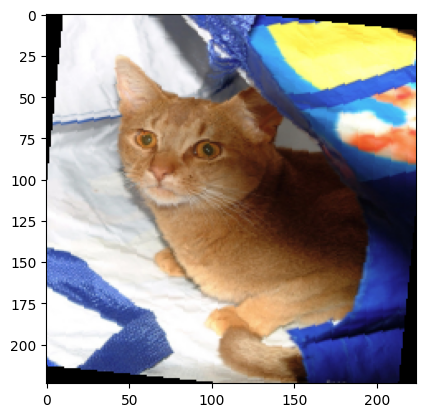

In [6]:
# First training label
print(training_data[0][1])
# First training image
plt.imshow(torch.permute(training_data[0][0], (1, 2, 0)))

Put the training and testing data into DataLoaders. Use a batch size of 100 for both sets, and shuffle the training data, but not the test data.

In [7]:
BATCH_SIZE = 100
train_loader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

# Constructing the Model

Now that the data is loaded, the next step is to construct the model. For this lab you want to begin with a model that has already been trained on Imagenet. We are going to use [alexnet](https://pytorch.org/vision/master/models/alexnet.html). A list of other models that are loaded in PyTorch can be found [here](https://pytorch.org/vision/0.9/models.html). Load the model with the Imagenet weights by using the option `weights='DEFAULT'`.

In [8]:
model = alexnet(weights='DEFAULT')

When using transfer learning there are usually two options. In the first option, only the weights in the final classifier layer are updated during training. In the second option, all the weights in the network are updated. We will start with option 1. This has the least chance of overfitting, since a small number of weights are being adjusted.

In the next cell we are going to turn off training of the network weights. Later we will modify the last layer of the network and turn training on for that layer only. To turn training off for a given set of parameters, you set `params.requires_grad` to `False`. All the model parameters are contained in the iterable `model.parameters()`.

In [9]:
for params in model.parameters():
    params.requires_grad = False

Print out the model to see: the network architecture, the label of the final classifier layer and the number of output features.

In [10]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

As you can see, the final layer of the classifier is `model.classifier[6]`. It has 1000 output features. Since we only have two categories (0 for cat and 1 for dog), we need to change `model.classifier[6].out_features` to 2.

In [11]:
model.classifier[6].out_features = 2

We will turn on training for that last `Linear` layer.

In [12]:
for params in model.classifier[6].parameters():
    params.requires_grad = True

After constructing the model, print a final summary to verify that we have 2 output features.

In [13]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Training the Network

The remainder of the training process is the same as it was in the first lab. The first step in training the network is to select the optimizer. Use `Adam` as the training function.

In [14]:
optimizer = torch.optim.Adam(model.parameters())

Assign the loss function as `nn.CrossEntropyLoss()`.

In [15]:
loss_fn = nn.CrossEntropyLoss()

Write a training loop. First, use a GPU if one is available. Train for 10 epochs, using the train_loader created above. Every 100 iterations, print out the training loss for the current minibatch, and save the loss for later plotting. (This is the same training loop from the first pytorch lab.)

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

total_loss =  []
ind =  []
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            total_loss.append(loss.item())
            ind.append(batch_idx + epoch*len(train_loader)/BATCH_SIZE)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


Plot the loss that you saved in the training loop.

In [ ]:
plt.plot(total_loss)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.show()

# Evaluate the Trained Model

In a loop of minibatches, using the test_loader, compute the overall accuracy of the network on the test set.

In [ ]:
# Testing loop
correct = 0
mistakes = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data.to(device))
        pred = output.argmax(dim=1, keepdim=True).cpu()
        mistakes.append(pred.eq(target.view_as(pred)))
        correct += pred.eq(target.view_as(pred)).sum().item()

print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



To check that you are not overfitting, calculate the accuracy on the training data. If the network was well trained, the accuracies should be similar.

In [ ]:
# Training loop
correct = 0
with torch.no_grad():
    for data, target in train_loader:
        output = model(data.to(device))
        pred = output.argmax(dim=1, keepdim=True).cpu()
        correct += pred.eq(target.view_as(pred)).sum().item()

print('\nTrain set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(train_loader.dataset),
    100. * correct / len(train_loader.dataset)))

## Explore Further

When using transfer learning there are a number of options available. Here are a few things you can try.

1. After training only the weights in the final layer, fine-tune the network by adjusting all the weights at the same time. What advantages do you find? What disadvantages? Be sure to compare training and testing performance. Do you think you should use a different learning rate when fine-tuning?
1. The network was initialized with weights learned from the Imagenet dataset. You can also start with random weights by leaving out the `weights` parameter. Try training the random network from scratch, first by only training the last layer and then by training all the weights. How do your results differ from when you used the pretrained network?
1. There are many other networks that can be loaded from `torchvision.models`, which you can find [here](https://pytorch.org/vision/0.9/models.html). Try some other networks and compare your results.